In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import glob
import os
import warnings
import numpy as np

from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

import sys
sys.path.append('/content/drive/MyDrive/ColabNotebooks/utils')
from sound_utils import extract_log_mel_windows_CNN, generate_dataset_from_list, load_sound_file
from misc import build_files_list, dump_pickle, load_pickle
from autoencoder import encoder, decoder, vae
from eval_perf import (
    get_prediction,
    plot_confusion_matrix,
    plot_histogram_by_class,
    plot_loss_per_epoch,
    plot_pr_curve,
    plot_roc_curve,
)

np.random.seed(42)

In [ ]:
import tensorflow as tf

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.python.client import device_lib

tf.random.set_seed(42)

In [ ]:
#random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
from bokeh.io import export_svgs, output_notebook, reset_output
from bokeh.models import BoxAnnotation, ColumnDataSource, HoverTool
from bokeh.plotting import figure, show
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    average_precision_score,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
)

output_notebook()

In [ ]:
n_fft = 1024
hop_length = 512
n_mels = 80
frames = 5

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


#Processing pipeline


1.   Load data
2.   Split into training, test and validation sets
3.   Extract log-Mel spectrograms
4.   Save the spectrograms



In [ ]:
root_dir = "/content/drive/MyDrive/ToyCar_data"
DATA_PATH = "/content/drive/MyDrive/ToyCar_data/ToyADMOS-anomaly-detection"
MODEL_PATH = "/content/drive/MyDrive/ToyCar_data/ToyADMOS-anomaly-detection"

In [ ]:
def build_files_list(root_dir):
    normal_files = []
    abnormal_files = []

    for root, _, files in os.walk(top=root_dir):
        for name in files:
            full_path = os.path.join(root, name)
            if root == "/content/drive/MyDrive/ToyCar_data/NormalSound":
                normal_files.append(full_path)
            elif root == "/content/drive/MyDrive/ToyCar_data/AnomalousSound":
                abnormal_files.append(full_path)

    return normal_files, abnormal_files

In [ ]:
#Train and Validation sets
# Load full file lists (assuming build_files_list returns two lists)
normal_files, abnormal_files = build_files_list(root_dir)

# Randomly sample 50% of each
normal_sample_indices = np.random.choice(len(normal_files), size=len(normal_files) // 2, replace=False)
abnormal_sample_indices = np.random.choice(len(abnormal_files), size=len(abnormal_files) // 2, replace=False)

normal_files_sampled = [normal_files[i] for i in normal_sample_indices]
abnormal_files_sampled = [abnormal_files[i] for i in abnormal_sample_indices]

# Create labels for the sampled files
normal_labels = np.zeros(len(normal_files_sampled))
abnormal_labels = np.ones(len(abnormal_files_sampled))

# Split normal files into train/val
train_files, val_files, train_labels, val_labels = train_test_split(
    normal_files_sampled, normal_labels, train_size=0.8, random_state=42, shuffle=True
)

# Add abnormal files to val set
val_files = np.concatenate((val_files, abnormal_files_sampled), axis=0)
val_labels = np.concatenate((val_labels, abnormal_labels), axis=0)

# Shuffle val set
val_indices = np.arange(len(val_files))
np.random.shuffle(val_indices)

val_files = val_files[val_indices]
val_labels = val_labels[val_indices]

# Print dataset stats
print(
    f"Train set has {train_labels.shape[0]} signals including abnormal {train_labels.sum():.0f} signals. "
    f"Validation set has {val_labels.shape[0]} signals including abnormal {val_labels.sum():.0f} signals."
)


Train set has 2160 signals including abnormal 0 signals. Validation set has 1069 signals including abnormal 529 signals.


In [ ]:
#Test set
# Load full file lists (assuming build_files_list returns two lists)
normal_files, abnormal_files = build_files_list(root_dir)

# Get the other half (the unselected indices)
other_normal_sample_indices = np.setdiff1d(np.arange(len(normal_files)), normal_sample_indices)
other_abnormal_sample_indices = np.setdiff1d(np.arange(len(abnormal_files)), abnormal_sample_indices)

other_normal_files_sampled = [normal_files[i] for i in other_normal_sample_indices]
other_abnormal_files_sampled = [abnormal_files[i] for i in other_abnormal_sample_indices]

# Create labels for the sampled files
other_normal_labels = np.zeros(len(other_normal_files_sampled))
other_abnormal_labels = np.ones(len(other_abnormal_files_sampled))

# Split normal files into train/test
other_train_files, test_files, other_train_labels, test_labels = train_test_split(
    other_normal_files_sampled, other_normal_labels, train_size=0.8, random_state=42, shuffle=True
)

# Add abnormal files to test set
test_files = np.concatenate((test_files, other_abnormal_files_sampled), axis=0)
test_labels = np.concatenate((test_labels, other_abnormal_labels), axis=0)

# Shuffle test set
test_indices = np.arange(len(test_files))
np.random.shuffle(test_indices)

test_files = test_files[test_indices]
test_labels = test_labels[test_indices]

# Print dataset stats
print(
    f"Test set has {test_labels.shape[0]} signals including abnormal {test_labels.sum():.0f} signals."
)


Test set has 1070 signals including abnormal 530 signals.


In [ ]:
dataset = {
    "train_files": train_files,
    "val_files": val_files,
    "test_files": test_files,
    "train_labels": train_labels,
    "val_labels": val_labels,
    "test_labels": test_labels,
}

for key, values in dataset.items():
    file_name = os.path.join(DATA_PATH, "dataset", key + "_VAE.txt")
    with open(file_name, "w") as f:
        for item in values:
            f.write(str(item) + "\n")

In [ ]:
# Extract spectrograms for training set

train_data_path = os.path.join(DATA_PATH, "dataset", "train_data_VAE_v3" + ".pkl")

if os.path.exists(train_data_path):
    print("Train data already exists, loading from file...")
    train_data = load_pickle(train_data_path)

else:
    train_data = generate_dataset_from_list(train_files)
    print("Saving train data to disk...")
    dump_pickle(train_data_path, train_data)
    print("Done.")

print(f"Train data has a {train_data.shape} shape.") # (num_windows_total, 5, 128, 1)

Train data already exists, loading from file...
Train data has a (734400, 5, 80, 1) shape.


In [ ]:
# Extract spectrograms for training set
n_fft = 1024
hop_length = 512
n_mels = 80
frames = 5

val_data_path = os.path.join(DATA_PATH, "dataset", "val_data_VAE_v3" + ".pkl")

if os.path.exists(val_data_path):
    print("Validation data already exists, loading from file...")
    val_data = load_pickle(val_data_path)

else:
    val_data = generate_dataset_from_list(val_files)
    print("Saving validation data to disk...")
    dump_pickle(val_data_path, val_data)
    print("Done.")

print(f"Validation data has a {val_data.shape} shape.") # (num_windows_total, 5, 128, 1)

Validation data already exists, loading from file...
Validation data has a (363460, 5, 80, 1) shape.


# Training VAE

In [ ]:
encoder.summary()
decoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 5, 80, 1)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encode_conv1        │ (None, 5, 40, 20) │        200 │ encoder_input[0]… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 5, 40, 20) │         80 │ encode_conv1[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encode_conv2        │ (None, 5, 20, 40) │      7,240 │ batch_normalizat… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 20, 40) │        160 │ encode_conv2[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encode_conv3        │ (None, 5, 10, 80) │     28,880 │ batch_normalizat… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 10, 80) │        320 │ encode_conv3[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encode_flatten      │ (None, 4000)      │          0 │ batch_normalizat… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encode_dense        │ (None, 16)        │     64,016 │ encode_flatten[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16)        │         64 │ encode_dense[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ latent_mu (Dense)   │ (None, 2)         │         34 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ latent_sigma        │ (None, 2)         │         34 │ batch_normalizat… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ latent_mu[0][0],  │
│                     │                   │            │ latent_sigma[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ kld_layer           │ ()                │          0 │ latent_mu[0][0],  │
│ (KLDLayer)          │                   │            │ latent_sigma[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 101,028 (394.64 KB)

 Trainable params: 100,716 (393.42 KB)

 Non-trainable params: 312 (1.22 KB)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decode_dense1 (Dense)           │ (None, 4000)           │        12,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decode_reshape (Reshape)        │ (None, 5, 10, 80)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decode_conv2d_1                 │ (None, 5, 20, 80)      │        57,680 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 5, 20, 80)      │           320 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decode_conv2d_2                 │ (None, 5, 40, 40)      │        28,840 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 5, 40, 40)      │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decode_conv2d_3                 │ (None, 5, 80, 20)      │         7,220 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 5, 80, 20)      │            80 │
│ (BatchNormalization)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 106,300 (415.23 KB)

 Trainable params: 106,020 (414.14 KB)

 Non-trainable params: 280 (1.09 KB)

In [ ]:
# Define global constants to be used in this notebook
%%time
batch_size = 128
epochs = 100

vae.compile(optimizer='adam',
            loss='mean_squared_error')

history = vae.fit(
    train_data,train_data,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    callbacks=[EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)],
    validation_data=(val_data, val_data),
    shuffle=True)

Epoch 1/100
5738/5738 ━━━━━━━━━━━━━━━━━━━━ 72s 10ms/step - loss: 1496.8091 - val_loss: 1116.4464
Epoch 2/100
5738/5738 ━━━━━━━━━━━━━━━━━━━━ 51s 9ms/step - loss: 975.0880 - val_loss: 675.7073
Epoch 3/100
5738/5738 ━━━━━━━━━━━━━━━━━━━━ 51s 9ms/step - loss: 582.9933 - val_loss: 365.5085
Epoch 4/100
5738/5738 ━━━━━━━━━━━━━━━━━━━━ 51s 9ms/step - loss: 311.3954 - val_loss: 165.7324
Epoch 5/100
5738/5738 ━━━━━━━━━━━━━━━━━━━━ 51s 9ms/step - loss: 146.9871 - val_loss: 67.3344
Epoch 6/100
5738/5738 ━━━━━━━━━━━━━━━━━━━━ 51s 9ms/step - loss: 56.4538 - val_loss: 25.1819
Epoch 7/100
5738/5738 ━━━━━━━━━━━━━━━━━━━━ 52s 9ms/step - loss: 19.9838 - val_loss: 15.2249
Epoch 8/100
5738/5738 ━━━━━━━━━━━━━━━━━━━━ 51s 9ms/step - loss: 15.3674 - val_loss: 15.3503
Epoch 9/100
5738/5738 ━━━━━━━━━━━━━━━━━━━━ 52s 9ms/step - loss: 15.3275 - val_loss: 15.7971
Epoch 10/100
5738/5738 ━━━━━━━━━━━━━━━━━━━━ 51s 9ms/step - loss: 15.3006 - val_loss: 15.3892
Epoch 11/100
5738/5738 ━━━━━━━━━━━━━━━━━━━━ 51s 9ms/step - loss: 15

In [ ]:
MODEL_NAME="Model2_VAE"

#Performance Evaluation for Validation set

---



In [ ]:
plot_loss_per_epoch(
    history, model_name=MODEL_NAME
)

In [ ]:
#Computes MSE (averaged_per_sample -> averaged_per_batch) between the original and reconstructed inputs.
#features = original input
#predictions = reconstructed version
#reconstruct the errors for the validation set
from tqdm import tqdm
import numpy as np

recon_errors = []

for file_path in tqdm(val_files, desc="Evaluating validation files"):
    # Extract log-mel spectrogram windows
    features = extract_log_mel_windows_CNN(
        file_path,
        sr=16000,
        n_fft=1024,
        hop_length=512,
        n_mels=80,
        frames=5
    )

    if features.size == 0:
        recon_errors.append(np.nan)
        continue

    # Predict reconstructed features from the model
    predictions = vae.predict(features, verbose=0)

    # Compute mean squared error per window and average over all windows
    mse_per_window = np.mean(np.square(features - predictions), axis=(1, 2, 3))  # shape: (num_windows,)
    file_error = np.mean(mse_per_window)
    recon_errors.append(file_error)

Evaluating validation files: 100%|██████████| 1069/1069 [06:52<00:00,  2.59it/s]


In [ ]:
recon_errors

[np.float32(9.554088),
 np.float32(8.398044),
 np.float32(11.607363),
 np.float32(8.505212),
 np.float32(18.935093),
 np.float32(15.772671),
 np.float32(18.08805),
 np.float32(15.076822),
 np.float32(9.471249),
 np.float32(16.193632),
 np.float32(8.253704),
 np.float32(16.49376),
 np.float32(10.326444),
 np.float32(9.584934),
 np.float32(8.19089),
 np.float32(8.145465),
 np.float32(8.922408),
 np.float32(14.88384),
 np.float32(9.163192),
 np.float32(16.075542),
 np.float32(9.1132145),
 np.float32(19.905148),
 np.float32(9.375493),
 np.float32(14.786588),
 np.float32(18.848866),
 np.float32(8.69779),
 np.float32(16.985748),
 np.float32(19.975939),
 np.float32(14.540062),
 np.float32(17.783792),
 np.float32(9.613753),
 np.float32(19.44429),
 np.float32(11.070715),
 np.float32(27.059364),
 np.float32(8.831475),
 np.float32(8.645855),
 np.float32(15.543713),
 np.float32(12.626884),
 np.float32(10.595802),
 np.float32(9.620112),
 np.float32(16.608465),
 np.float32(8.47942),
 np.float32(19.9

In [ ]:
stack = np.column_stack((range(len(recon_errors)), recon_errors))
score_false = stack[val_labels == 0][:, 1]
score_true = stack[val_labels == 1][:, 1]

plot_histogram_by_class(
    score_false,
    score_true,
    bins=[20, 30],
    model_name=MODEL_NAME,
)

In [ ]:
THRESHOLD_MIN = 0.0
THRESHOLD_MAX = 10

p = figure(
    width=600,
    height=400,
    title=f"{MODEL_NAME}: Threshold Range Exploration",
    x_axis_label="Samples",
    y_axis_label="Reconstruction Error",
)

source = ColumnDataSource(
    dict(index=stack[val_labels == 0][:, 0], error=stack[val_labels == 0][:, 1])
)

p.scatter(
    "index",
    "error",
    fill_alpha=0.6,
    fill_color="crimson",
    line_color=None,
    legend_label="Normal Signals",
    source=source,
)

source = ColumnDataSource(
    dict(index=stack[val_labels == 1][:, 0], error=stack[val_labels == 1][:, 1])
)

p.scatter(
    "index",
    "error",
    fill_alpha=0.6,
    fill_color="indigo",
    line_color=None,
    legend_label="Abnormal Signals",
    source=source,
)

source = ColumnDataSource(
    data=dict(
        index=stack[:, 0],
        threshold_min=np.repeat(THRESHOLD_MIN, stack.shape[0]),
        threshold_max=np.repeat(THRESHOLD_MAX, stack.shape[0]),
    )
)

box = BoxAnnotation(
    bottom=THRESHOLD_MIN,
    top=THRESHOLD_MAX,
    fill_alpha=0.1,
    fill_color="magenta",
    line_color="darkmagenta",
    line_width=1.0,
)
p.add_layout(box)

p.legend.label_text_font_size = "8pt"
p.legend.location = "top_right"
p.title.align = "center"
p.title.text_font_size = "12pt"

p.add_tools(HoverTool(tooltips=[("index", "@index"), ("error", "@error")]))

show(p)

In [ ]:
THRESHOLD_MIN = 0.00
THRESHOLD_MAX = 20
THRESHOLD_STEP = 0.5

thresholds = np.arange(THRESHOLD_MIN, THRESHOLD_MAX + THRESHOLD_STEP, THRESHOLD_STEP)
errors = []

for threshold in thresholds:
    predictions = get_prediction(stack[:, 1], threshold=threshold)
    conf_mat = confusion_matrix(val_labels, predictions)
    errors.append([threshold, conf_mat[1, 0], conf_mat[0, 1]])

errors = np.array(errors)

p = figure(
    width=600,
    height=400,
    title=f"{MODEL_NAME}: Best Threshold Exploration",
    x_axis_label="Reconstruction Error Threshold (%)",
    y_axis_label="# Samples",
)

source = ColumnDataSource(
    data=dict(
        threshold=errors[:, 0], false_negative=errors[:, 1], false_positive=errors[:, 2]
    )
)

p.line(
    x="threshold",
    y="false_negative",
    color="crimson",
    legend_label="False Negative",
    source=source,
)

p.line(
    x="threshold",
    y="false_positive",
    color="indigo",
    legend_label="False Positive",
    source=source,
)

p.legend.label_text_font_size = "8pt"
p.legend.location = "top_left"
p.legend.click_policy = "hide"
p.title.align = "center"
p.title.text_font_size = "12pt"

p.add_tools(
    HoverTool(
        tooltips=[
            ("threshold", "@threshold"),
            ("false_negative", "@false_negative"),
            ("false_positive", "@false_positive"),
        ]
    )
)
show(p)


In [ ]:
THRESHOLD = 10
predictions = get_prediction(stack[:, 1], threshold=THRESHOLD)

plot_confusion_matrix(
    confusion_matrix(val_labels, predictions),
    #model_name=MODEL_NAME,
)

print(
    f"Accuracy: {accuracy_score(val_labels, predictions):.2%}, \
Precision: {precision_score(val_labels, predictions):.2%}, \
Recall: {recall_score(val_labels, predictions):.2%}, \
F1: {f1_score(val_labels, predictions):.2%}"
)

Accuracy: 97.66%, Precision: 97.55%, Recall: 97.73%, F1: 97.64%


In [ ]:
plot_roc_curve(
    roc_curve(val_labels, recon_errors),
    roc_auc_score(val_labels, recon_errors),

    model_name=MODEL_NAME
)

In [ ]:
auc=roc_auc_score(val_labels, recon_errors)

print(f"AUC score: {auc:.4f}")

AUC score: 0.9945


In [ ]:
plot_pr_curve(
    precision_recall_curve(val_labels, recon_errors),
    average_precision_score(val_labels, recon_errors),
    model_name=MODEL_NAME
)

In [ ]:
from sklearn.metrics import roc_curve, auc
import numpy as np

def compute_partial_auc(y_true, y_scores, max_fpr=0.1):
    fpr, tpr, _ = roc_curve(y_true, y_scores)

    # Keep only points where FPR <= max_fpr
    mask = fpr <= max_fpr
    fpr_partial = fpr[mask]
    tpr_partial = tpr[mask]

    # Interpolate to add (max_fpr, interpolated_tpr) if needed
    if fpr_partial[-1] < max_fpr:
        # Find next point beyond max_fpr
        idx = np.searchsorted(fpr, max_fpr)
        fpr_left, fpr_right = fpr[idx - 1], fpr[idx]
        tpr_left, tpr_right = tpr[idx - 1], tpr[idx]

        # Linear interpolation
        slope = (tpr_right - tpr_left) / (fpr_right - fpr_left)
        tpr_interp = tpr_left + slope * (max_fpr - fpr_left)

        fpr_partial = np.append(fpr_partial, max_fpr)
        tpr_partial = np.append(tpr_partial, tpr_interp)

    return auc(fpr_partial, tpr_partial)

# Usage
pauc = compute_partial_auc(val_labels, recon_errors, max_fpr=0.1)
print(f"Unnormalized Partial AUC (FPR ≤ 0.1): {pauc:.4f} or the model performs {(pauc/0.1):.1%} as well as a perfect classifier in the region where FPR ≤ 0.1.")

#pauc/0.1 * 100

Unnormalized Partial AUC (FPR ≤ 0.1): 0.0965 or the model performs 96.5% as well as a perfect classifier in the region where FPR ≤ 0.1.


#Performance Evaluation for Test set

In [ ]:
recon_errors = []

for file_path in tqdm(test_files, desc="Evaluating test files"):
    # Extract log-mel spectrogram windows
    features = extract_log_mel_windows_CNN(
        file_path,
        sr=16000,
        n_fft=1024,
        hop_length=512,
        n_mels=80,
        frames=5
    )

    if features.size == 0:
        recon_errors.append(np.nan)
        continue

    # Predict reconstructed features from the model
    predictions = vae.predict(features, verbose=0)

    # Compute mean squared error per window and average over all windows
    mse_per_window = np.mean(np.square(features - predictions), axis=(1, 2, 3))  # shape: (num_windows,)
    file_error = np.mean(mse_per_window)
    recon_errors.append(file_error)

Evaluating test files: 100%|██████████| 1070/1070 [06:43<00:00,  2.65it/s]


In [ ]:
stack = np.column_stack((range(len(recon_errors)), recon_errors))
score_false = stack[test_labels == 0][:, 1]
score_true = stack[test_labels == 1][:, 1]

plot_histogram_by_class(
    score_false,
    score_true,
    bins=[20, 30],
    model_name=MODEL_NAME,
)

In [ ]:
THRESHOLD_MIN = 8.0
THRESHOLD_MAX = 10.0

p = figure(
    width=600,
    height=400,
    title=f"{MODEL_NAME}: Threshold Range Exploration",
    x_axis_label="Samples",
    y_axis_label="Reconstruction Error",
)

source = ColumnDataSource(
    dict(index=stack[test_labels == 0][:, 0], error=stack[test_labels == 0][:, 1])
)

p.scatter(
    "index",
    "error",
    fill_alpha=0.6,
    fill_color="crimson",
    line_color=None,
    legend_label="Normal Signals",
    source=source,
)

source = ColumnDataSource(
    dict(index=stack[test_labels == 1][:, 0], error=stack[test_labels == 1][:, 1])
)

p.scatter(
    "index",
    "error",
    fill_alpha=0.6,
    fill_color="indigo",
    line_color=None,
    legend_label="Abnormal Signals",
    source=source,
)

source = ColumnDataSource(
    data=dict(
        index=stack[:, 0],
        threshold_min=np.repeat(THRESHOLD_MIN, stack.shape[0]),
        threshold_max=np.repeat(THRESHOLD_MAX, stack.shape[0]),
    )
)

box = BoxAnnotation(
    bottom=THRESHOLD_MIN,
    top=THRESHOLD_MAX,
    fill_alpha=0.1,
    fill_color="magenta",
    line_color="darkmagenta",
    line_width=1.0,
)
p.add_layout(box)

p.legend.label_text_font_size = "8pt"
p.legend.location = "top_right"
p.title.align = "center"
p.title.text_font_size = "12pt"

p.add_tools(HoverTool(tooltips=[("index", "@index"), ("error", "@error")]))

show(p)

In [ ]:
THRESHOLD_MIN = 0.0
THRESHOLD_MAX = 20.0
THRESHOLD_STEP = 0.5

thresholds = np.arange(THRESHOLD_MIN, THRESHOLD_MAX + THRESHOLD_STEP, THRESHOLD_STEP)
errors = []

for threshold in thresholds:
    predictions = get_prediction(stack[:, 1], threshold=threshold)
    conf_mat = confusion_matrix(test_labels, predictions)
    errors.append([threshold, conf_mat[1, 0], conf_mat[0, 1]])

errors = np.array(errors)

p = figure(
    width=600,
    height=400,
    title=f"{MODEL_NAME}: Best Threshold Exploration",
    x_axis_label="Reconstruction Error Threshold (%)",
    y_axis_label="# Samples",
)

source = ColumnDataSource(
    data=dict(
        threshold=errors[:, 0], false_negative=errors[:, 1], false_positive=errors[:, 2]
    )
)

p.line(
    x="threshold",
    y="false_negative",
    color="crimson",
    legend_label="False Negative",
    source=source,
)

p.line(
    x="threshold",
    y="false_positive",
    color="indigo",
    legend_label="False Positive",
    source=source,
)

p.legend.label_text_font_size = "8pt"
p.legend.location = "top_left"
p.legend.click_policy = "hide"
p.title.align = "center"
p.title.text_font_size = "12pt"

p.add_tools(
    HoverTool(
        tooltips=[
            ("threshold", "@threshold"),
            ("false_negative", "@false_negative"),
            ("false_positive", "@false_positive"),
        ]
    )
)
show(p)


In [ ]:
THRESHOLD = 10
predictions = get_prediction(stack[:, 1], threshold=THRESHOLD)

plot_confusion_matrix(
    confusion_matrix(test_labels, predictions),
    model_name=MODEL_NAME,
)

print(
    f"Accuracy: {accuracy_score(test_labels, predictions):.2%}, \
Precision: {precision_score(test_labels, predictions):.2%}, \
Recall: {recall_score(test_labels, predictions):.2%}, \
F1: {f1_score(test_labels, predictions):.2%}"
)

Accuracy: 97.29%, Precision: 97.18%, Recall: 97.36%, F1: 97.27%


In [ ]:
plot_roc_curve(
    roc_curve(test_labels, recon_errors),
    roc_auc_score(test_labels, recon_errors),

    model_name=MODEL_NAME
)

In [ ]:
auc=roc_auc_score(test_labels, recon_errors)

print(f"AUC score: {auc:.4f}")

AUC score: 0.9935


In [ ]:
from sklearn.metrics import roc_curve, auc
import numpy as np

def compute_partial_auc(y_true, y_scores, max_fpr=0.1):
    fpr, tpr, _ = roc_curve(y_true, y_scores)

    # Keep only points where FPR <= max_fpr
    mask = fpr <= max_fpr
    fpr_partial = fpr[mask]
    tpr_partial = tpr[mask]

    # Interpolate to add (max_fpr, interpolated_tpr) if needed
    if fpr_partial[-1] < max_fpr:
        # Find next point beyond max_fpr
        idx = np.searchsorted(fpr, max_fpr)
        fpr_left, fpr_right = fpr[idx - 1], fpr[idx]
        tpr_left, tpr_right = tpr[idx - 1], tpr[idx]

        # Linear interpolation
        slope = (tpr_right - tpr_left) / (fpr_right - fpr_left)
        tpr_interp = tpr_left + slope * (max_fpr - fpr_left)

        fpr_partial = np.append(fpr_partial, max_fpr)
        tpr_partial = np.append(tpr_partial, tpr_interp)

    return auc(fpr_partial, tpr_partial)

# Usage
pauc = compute_partial_auc(test_labels, recon_errors, max_fpr=0.02)
print(f"Unnormalized Partial AUC (FPR ≤ 0.1): {pauc:.4f} or the model performs {(pauc/0.1):.1%} as well as a perfect classifier in the region where FPR ≤ 0.1.")

#pauc/0.1 * 100

Unnormalized Partial AUC (FPR ≤ 0.1): 0.0162 or the model performs 16.2% as well as a perfect classifier in the region where FPR ≤ 0.1.


#t-SNE visualization

In [ ]:
num_samples = val_data.shape[0]
batch_size = 128

for i in range(0, num_samples, batch_size):
    x_batch = val_data[i:i+batch_size]
    z = encoder(x_batch, training=False)
    print(f"Batch {i//batch_size} output type: {type(z)}")
    print(f"Batch {i//batch_size} output: {z}")
    break  # just check the first batch


NameError: name 'encoder' is not defined

In [ ]:
# Function to extract latent vectors from model
def extract_latents_from_array(encoder_model, data, batch_size=batch_size):
    latent_vectors = []
    num_samples = data.shape[0]

    for i in range(0, num_samples, batch_size):
        x_batch = data[i:i+batch_size]
        z, _ = encoder_model(x_batch, training=False)  # get latent vectors and ignore KL loss
        latent_vectors.append(z.numpy())

    latent_vectors = np.concatenate(latent_vectors, axis=0)
    return latent_vectors

In [ ]:
latent_vecs = extract_latents_from_array(encoder, val_data, batch_size=batch_size)

print(f"Latent vectors shape: {latent_vecs.shape}")

Latent vectors shape: (363460, 2)


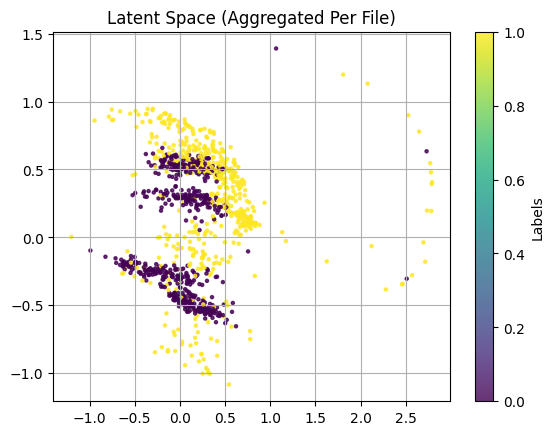

In [ ]:
# Assume latent_vecs.shape = (363460, latent_dim)
latent_dim = latent_vecs.shape[1]
latent_vecs_per_file = latent_vecs.reshape(val_labels.shape[0], -1, latent_dim)
latent_means = latent_vecs_per_file.mean(axis=1)  # shape: (1069, latent_dim)

plt.scatter(latent_means[:, 0], latent_means[:, 1], c=val_labels, cmap='viridis', s=5, alpha=0.8)
plt.colorbar(label="Labels")
plt.title("Latent Space (Aggregated Per File)")
plt.grid(True)
plt.show()

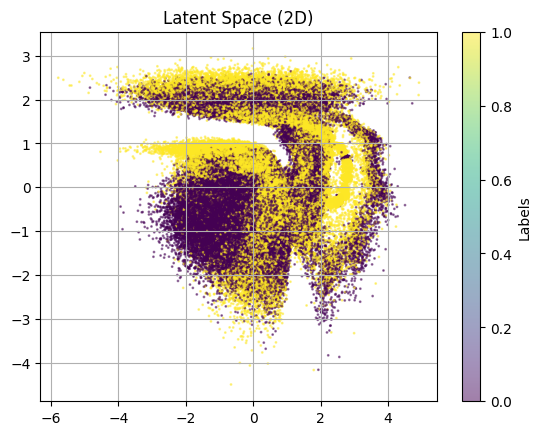

In [ ]:
plt.scatter(latent_vecs[:, 0], latent_vecs[:, 1], c=expanded_labels, cmap='viridis', s=1, alpha=0.5)
plt.colorbar(label="Labels")
plt.title("Latent Space (2D)")
plt.grid(True)
plt.show()